In [1]:
# !pip install cairosvg

In [2]:
import ast
import cairosvg
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
from pathlib import Path

from typing import Tuple, List, Dict

In [3]:
def get_sample_size_wise_performance_metrics(sample_sizes: List[int],
                                             metrics_dir: str) -> Tuple[List[List[float]]]:
    
    precision_list: List[List[float]] = list()
    recall_list: List[List[float]] = list()
    f1_list: List[List[float]] = list()
    
    for sample_size in sample_sizes:

        sample_precision_list: List[float] = list()
        sample_recall_list: List[float] = list()
        sample_f1_list: List[float] = list()

        for item in glob.glob(os.path.join(metrics_dir, str(sample_size//1000)+"*.txt")):
            # print(item)
            with open((Path(item)), "r") as file_reader:
                sample_fold_dict_str: str = file_reader.read()
                sample_fold_dict: Dict = ast.literal_eval(sample_fold_dict_str)
                
                sample_precision_list.append(sample_fold_dict["macro avg"]["precision"])
                sample_recall_list.append(sample_fold_dict["macro avg"]["recall"])
                sample_f1_list.append(sample_fold_dict["macro avg"]["f1-score"])

        precision_list.append(sample_precision_list)
        recall_list.append(sample_recall_list)
        f1_list.append(sample_f1_list)
    
    return precision_list, recall_list, f1_list

In [4]:
# Sample sizes
metrics_dir = os.path.join(*["ner_performance_metrics", "mt5"])
sample_sizes = [3_000, 4_000, 5_000, 6_000, 7_000, 8_000, 9_000, 10_000]

precision, recall, f1_score = get_sample_size_wise_performance_metrics(sample_sizes, metrics_dir)

precision = np.array(precision)
recall = np.array(recall)
f1_score = np.array(f1_score)

# Mean and standard deviation
precision_mean = precision.mean(axis=1)
precision_std = precision.std(axis=1)

recall_mean = recall.mean(axis=1)
recall_std = recall.std(axis=1)

f1_mean = f1_score.mean(axis=1)
f1_std = f1_score.std(axis=1)

In [5]:
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

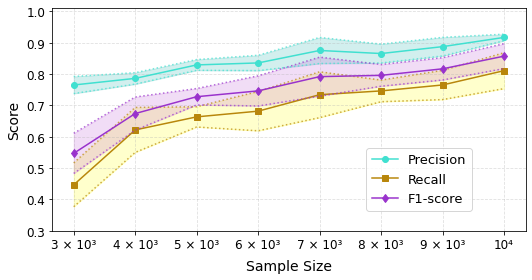

In [6]:
# Plotting a line plot with shaded error bars
fig, ax = plt.subplots(figsize=(7.5, 4))

# Plot Precision
ax.plot(sample_sizes, precision_mean, marker='o', linestyle='-', label='Precision', color="turquoise")
ax.fill_between(sample_sizes, precision_mean - precision_std, precision_mean + precision_std, alpha=0.2, color="lightseagreen")
ax.plot(sample_sizes, precision_mean - precision_std, linestyle='dotted', color='turquoise', alpha=0.7)
ax.plot(sample_sizes, precision_mean + precision_std, linestyle='dotted', color='turquoise', alpha=0.7)

# Plot Recall
ax.plot(sample_sizes, recall_mean, marker='s', linestyle='-', label='Recall', color="darkgoldenrod")
ax.fill_between(sample_sizes, recall_mean - recall_std, recall_mean + recall_std, alpha=0.2, color="yellow")
ax.plot(sample_sizes, recall_mean - recall_std, linestyle='dotted', color='darkgoldenrod', alpha=0.7)
ax.plot(sample_sizes, recall_mean + recall_std, linestyle='dotted', color='darkgoldenrod', alpha=0.7)

# Plot F1-score
ax.plot(sample_sizes, f1_mean, marker='d', linestyle='-', label='F1-score', color="darkorchid")
ax.fill_between(sample_sizes, f1_mean - f1_std, f1_mean + f1_std, alpha=0.2, color="mediumorchid")
ax.plot(sample_sizes, f1_mean - f1_std, linestyle='dotted', color='darkorchid', alpha=0.7)
ax.plot(sample_sizes, f1_mean + f1_std, linestyle='dotted', color='darkorchid', alpha=0.7)

# Labels and formatting
ax.set_xlabel('Sample Size', fontsize=14, labelpad=8)
ax.set_ylabel('Score', fontsize=14, labelpad=5)
ax.set_ylim(0.30, 1.01)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1000)} × 10³" if x < 10000 else "10⁴"))
ax.legend(bbox_to_anchor=(0.9, 0.4), fontsize=13)
ax.grid(True, which='both', linestyle='--', alpha=0.4)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

plot_file_ext = "svg"
plot_name = "entity_prediction_performance_of_ner_pg_model_across_different_sample_sizes_line"
plot_file_name = f"{plot_name}.{plot_file_ext}"
plot_file_path = os.path.join(plots_dir, plot_file_name)
plt.savefig(plot_file_path, format=plot_file_ext, dpi=1200, bbox_inches='tight')

# Convert to pdf
plot_pdf_name = f"{plot_name}.pdf"
plot_pdf_path = os.path.join(plots_dir, plot_pdf_name)
cairosvg.svg2pdf(url=plot_file_path, write_to=plot_pdf_path)

# Show plot
plt.tight_layout()
plt.show()

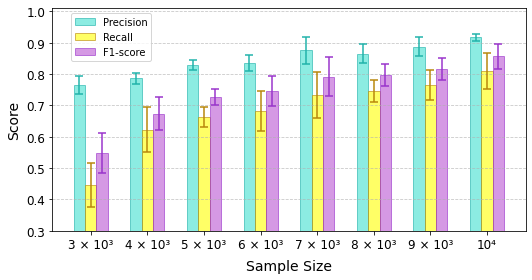

In [7]:
# Plotting a bar plot with error bars
fig, ax = plt.subplots(figsize=(7.5, 4))

xtick_labels = [f"{s//1000} × 10³" if s < 10000 else "10⁴" for s in sample_sizes]

bar_width = 0.20
index = np.arange(len(sample_sizes))

ax.bar(
    index, 
    precision_mean, 
    bar_width, 
    yerr=precision_std, 
    label='Precision',
    color="turquoise",
    edgecolor="lightseagreen",
    alpha=0.6,
    error_kw = {
        'ecolor': 'lightseagreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
ax.bar(
    index + bar_width, 
    recall_mean, 
    bar_width, 
    yerr=recall_std, 
    label='Recall', 
    color="yellow",
    edgecolor="darkgoldenrod",
    alpha=0.6,
    error_kw = {
        'ecolor': 'darkgoldenrod',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
ax.bar(
    index + 2 * bar_width,
    f1_mean,
    bar_width,
    yerr=f1_std,
    label='F1-score',
    color="mediumorchid",
    edgecolor="darkorchid",
    alpha=0.6,
    error_kw = {
        'ecolor': 'darkorchid',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    })

# Labels and formatting
ax.set_xlabel('Sample Size', fontsize=14, labelpad=8)
ax.set_ylabel('Score', fontsize=14, labelpad=5)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(xtick_labels)
ax.set_ylim(0.30, 1.01)
ax.set_yticks(np.arange(0.30, 1.04, 0.10))
ax.legend(bbox_to_anchor=(0.22, 0.74), fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

plot_file_ext = "svg"
plot_name = "entity_prediction_performance_of_ner_pg_model_across_different_sample_sizes_bar"
plot_file_name = f"{plot_name}.{plot_file_ext}"
plot_file_path = os.path.join(plots_dir, plot_file_name)
plt.savefig(plot_file_path, format=plot_file_ext, dpi=1200, bbox_inches='tight')

# Convert to pdf
plot_pdf_name = f"{plot_name}.pdf"
plot_pdf_path = os.path.join(plots_dir, plot_pdf_name)
cairosvg.svg2pdf(url=plot_file_path, write_to=plot_pdf_path)

# Show plot
plt.tight_layout()
plt.show()